**Librerias**

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

**Cargar datos**

In [126]:
df =  pd.read_excel("../data/interim/REPORTE_RECORD_ESTUDIANTIL_ANONIMIZADO.xlsx")

**Eliminar columnas sobrantes**

In [127]:
columnsToDrop = ['FACULTAD', 'CARRERA', 'MATERIA', 'COD_GRUPO', 'GRUPO/PARALELO']

In [128]:
df.drop(columns=columnsToDrop, inplace=True)

**Agregación por Estudiante-Periodo**

In [129]:
agg = (
    df.groupby(["ESTUDIANTE", "PERIODO"])
      .agg(
          PROM_PERIODO=("PROMEDIO", "mean"),
          ASIST_PROM=("ASISTENCIA", "mean"),
          TOTAL_MAT=("COD_MATERIA", "count"),
          REPROBADAS=("ESTADO", lambda x: (x == "REPROBADA").sum()),
          REPITENCIAS=("NO. VEZ", lambda x: (x >= 2).sum()),
          NIVEL=("NIVEL", "max")
      )
      .reset_index()
)

In [130]:
agg["PROP_REPROB"] = agg["REPROBADAS"] / agg["TOTAL_MAT"]

**Definir la variable objetivo**


Un estudiante está en riesgo si cumple ≥ N criterios de riesgo
- `RIESGO_DESERCION = 1` si el estudiante cumple al menos 3 criterios de riesgo
- `RIESGO_DESERCION = 0` sin riesgo de deserción

In [114]:
agg["RIESGO_SCORE"] = (
    (agg["PROP_REPROB"] >= 0.5).astype(int) +
    (agg["ASIST_PROM"] < 70).astype(int) +
    (agg["PROM_PERIODO"] < 6).astype(int) +
    (agg["REPITENCIAS"] >= 1).astype(int) +
    (agg["NIVEL"] <= 2).astype(int)
)

agg["RIESGO_t"] = (agg["RIESGO_SCORE"] >= 3).astype(int)

In [115]:
agg = agg.sort_values(["ESTUDIANTE", "PERIODO"])
agg["RIESGO_t1"] = agg.groupby("ESTUDIANTE")["RIESGO_t"].shift(-1)

La variable objetivo fue desplazada temporalmente al período académico siguiente (t+1), permitiendo entrenar modelos predictivos que utilizan únicamente información disponible en el período actual, evitando sesgos por fuga de información y simulando un escenario real de toma de decisiones.

In [123]:
dataset = agg.dropna(subset=["RIESGO_t1"]).copy()
dataset["RIESGO_t1"] = dataset["RIESGO_t1"].astype(int)
dataset["RIESGO_t1"].value_counts(normalize=True) * 100

RIESGO_t1
0    89.043478
1    10.956522
Name: proportion, dtype: float64

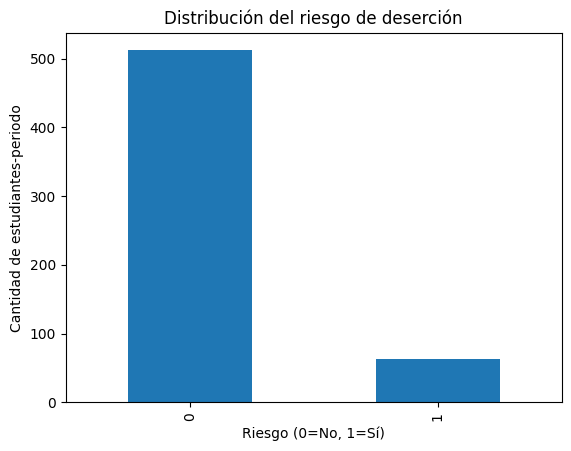

In [121]:
plt.figure()
dataset["RIESGO_t1"].value_counts().plot(kind="bar")
plt.title("Distribución del riesgo de deserción")
plt.xlabel("Riesgo (0=No, 1=Sí)")
plt.ylabel("Cantidad de estudiantes-periodo")
plt.show()

El conjunto de datos fue transformado a una estructura temporal estudiante–período, permitiendo definir una variable objetivo dinámica que representa el riesgo de deserción en el período siguiente, evitando el uso de información futura y garantizando consistencia temporal.

In [124]:
# Guardar datos listos para el modelado
dataset.to_excel("../data/processed/REPORTE_RECORD_ESTUDIANTIL_ANONIMIZADO.xlsx", index=False)